In [205]:
import pandas as pd

# df = pd.DataFrame(pd.read_csv("Channels.csv"))

# channels_dict=df.set_index('labels')['urchan']
# channels_dict

In [206]:
import mne
import os
from pathlib import Path
# import cupy
import numpy as np

In [207]:
data_dir = Path("/Users/adelechen/Desktop/CMPSC 445/EEG data/eyesOpen")

data_all = []
labels_all = []

single_set = mne.io.read_raw_eeglab('/Users/adelechen/Desktop/CMPSC 445/EEG data/eyesOpen/01_eyesOpen.set', preload=True)
channels = single_set.info['ch_names'][2:10] + single_set.info['ch_names'][44:46]
#[set].pick(channel_nums)

# os.environ['MNE_USE_CUDA'] = 'true' 
# mne.utils.set_config('MNE_USE_CUDA', 'true') 
# mne.cuda.init_cuda(ignore_config=True)  

In [208]:
MIN_POINTS = 100  #Minimum number of time points per trial
TARGET_SAMPLING_RATE = 250

for file_path in data_dir.glob("*.set"):
    file_name = file_path.stem
    if "PREP" not in file_name:
        number = int(file_name.split('_')[0])
        label = 1 if number % 2 == 1 else 0  # 1 = Parkinson's, 0 = Non-Parkinson's
        
        #Load the .set file
        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        
        raw.pick(channels)

        #Re-reference to the average reference
        raw.set_eeg_reference('average', projection=True)

        #Downsample to the target sampling rate
        raw.resample(TARGET_SAMPLING_RATE, npad="auto")

        #Bandpass filter
        raw.filter(1., 30., fir_design='firwin')

        #Apply ICA
        ica = mne.preprocessing.ICA(n_components=7, random_state=22, max_iter=1000, method='fastica')
        ica.fit(raw)
        raw = ica.apply(raw)

        # Convert to numpy format
        data = raw.get_data()  # (n_channels, n_times)
        data = data.T

        if data.shape[0] >= MIN_POINTS:
            data_all.append(data)
            labels_all.append(label)

print("Valid Trials:", len(data_all))


#minimum length of filtered data
target_length = min(data.shape[0] for data in data_all)

#Standardize the shape of each array in data_all
for i, data in enumerate(data_all):
    if data.shape[0] > target_length:
        #Shorten long arrays
        data_all[i] = data[:target_length, :]
    # elif data.shape[0] < target_length:
    #     #Lengthen short arrays
    #     padding = target_length - data.shape[0]
    #     data_all[i] = np.pad(data, ((0, padding), (0, 0)), mode="constant")

data_all = np.stack(data_all)#(n_trials, n_times, n_channels)
labels_all = np.array(labels_all)

# Check the shapes of the final dataset
print("Final dataset shape:",data_all.shape,"(trials, time points, channels)")
print("Labels shape:",labels_all.shape)

X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.25, random_state=39, stratify=labels_all)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 0.0s.
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
  

/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Projecting back using 10 PCA components
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
   

In [209]:
import torch
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [210]:
#Train test split
###X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=None)
#X_train_tensor = torch.from_numpy(X_train).float()
#X_test_tensor = torch.from_numpy(X_test).float()
#y_train_tensor = torch.from_numpy(y_train).long()
#y_test_tensor = torch.from_numpy(y_test).long()

 
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
#test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)


In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

def preprocess_data(X_train, X_test):
    #Flatten the data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    #Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    
    return X_train_scaled, X_test_scaled

def train_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test):
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train_scaled, y_train)
    
    y_pred = lr_model.predict(X_test_scaled)
    print("\nLogistic Regression Results:")
    print(classification_report(y_test, y_pred))
    return lr_model

def train_logistic_regression_with_cv(X, y, cv_folds=5):
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=None)
    
    scores = cross_validate(
        lr_model, X, y, cv=cv, scoring=['accuracy', 'precision','f1','recall'],
        return_train_score=True, return_estimator=True
    )
    
    # print("Cross-Validation Results:")
    # for key in scores.keys():
    #     print(key,":",scores[key])
    #Return the model with the best performance on validation data
    best_model_index = np.argmax(scores['test_accuracy'])
    best_model = scores['estimator'][best_model_index]
    
    return best_model

In [212]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_comparison(X_train, X_test, y_train, y_test):
    #Logistic Regression
    print("Training Logistic Regression...")
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
    lr_model = train_logistic_regression(X_train_scaled, y_train, X_test_scaled, y_test)
    
    #Logistic Regression with cv
    print("Training Logistic Regression with cv...")
    X_combined = np.vstack((X_train_scaled, X_test_scaled))
    y_combined = np.hstack((y_train, y_test))
    best_model= train_logistic_regression_with_cv(X_combined, y_combined, cv_folds=8)
    y_pred = best_model.predict(X_test_scaled)
    print("\nTest Set Results:")
    print(classification_report(y_test, y_pred))
    
    return lr_model, best_model

# lr_model, best_model = run_comparison(X_train, X_test, y_train, y_test)

X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.67      0.40      0.50         5

    accuracy                           0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10


Confusion Matrix:
[[4 1]
 [3 2]]


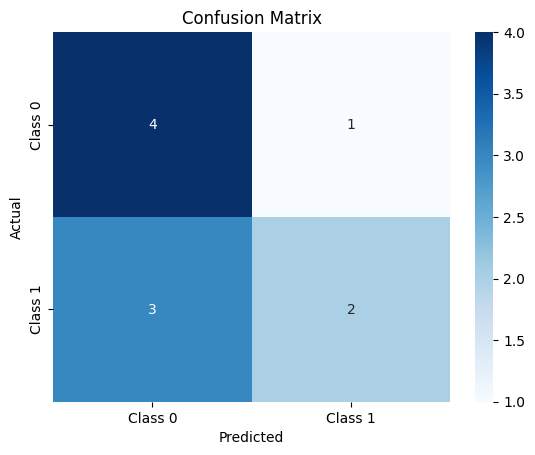

In [213]:

best_model = train_logistic_regression_with_cv(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

#accuracy = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#print(f"Accuracy: {accuracy:.2f}")
#print(f"Precision: {precision:.2f}")
#print(f"Recall: {recall:.2f}")
#print(f"F1 Score: {f1:.2f}")

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Heatmap for confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [214]:
# For running 10 iterations and calculating avg

results = {"accuracy": [], "precision_0": [], "recall_0": [], "f1_0": [], "precision_1": [], "recall_1": [], "f1_1": []}  

for i in range(10):
    print(f"\nRun {i + 1}")
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.2, random_state=None)
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
    #lr_model, best_model = run_comparison(X_train, X_test, y_train, y_test)

    print("Training Logistic Regression with cv...")
    X_combined = np.vstack((X_train_scaled, X_test_scaled))
    y_combined = np.hstack((y_train, y_test))
    best_model= train_logistic_regression_with_cv(X_combined, y_combined, cv_folds=8)
    y_pred = best_model.predict(X_test_scaled)
    print("\nTest Set Results:")
    print(classification_report(y_test, y_pred))
    
    report = classification_report(y_test, y_pred, output_dict=True)
    results["accuracy"].append(report["accuracy"])
    results["precision_0"].append(report["0"]["precision"])
    results["recall_0"].append(report["0"]["recall"])
    results["f1_0"].append(report["0"]["f1-score"])
    results["precision_1"].append(report["1"]["precision"])
    results["recall_1"].append(report["1"]["recall"])
    results["f1_1"].append(report["1"]["f1-score"])

averages = {metric: np.mean(values) for metric, values in results.items()}
print("10-run average:")
for metric, avg_value in averages.items():
    print(f"{metric}: {avg_value:.2f}")


Run 1
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         7

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 2
Training Logistic Regression with cv...

Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 3
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 4
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 5
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 6
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 7
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera


Test Set Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8


Run 8
Training Logistic Regression with cv...


/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adelechen/PycharmProjects/445 EEG Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 